# RAG chat client using LangGraph

Provides
- Streaming
- History

#### Install needed packages

In [1]:
%pip install --upgrade --quiet langgraph langchain-openai

Note: you may need to restart the kernel to use updated packages.


#### Check that required API keys are available in environment variables

In [2]:
import os
if not os.environ.get('OPENAI_API_KEY'): print('Warning: OPENAI_API_KEY not found')

## Retriever

Load documents into an in-memory vector store

In [3]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import MarkdownHeaderTextSplitter
import requests

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()
vector_store = InMemoryVectorStore(embeddings)

markdown = requests.get('https://rsnyder.github.io/schh-ai-chatbot/knowledge-base/general/2025ScheduleOfFeesAndCommunityRules.md').text

# MD splits
all_splits = MarkdownHeaderTextSplitter(
    headers_to_split_on = [ ('#', 'Header 1'), ('##', 'Header 2'), ('###', 'Header 3') ], 
    strip_headers=False
).split_text(markdown)

vector_store.add_documents(documents=all_splits)
retriever = vector_store.as_retriever()

### Create a retriever tool

In [4]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_community_rules",
    "Search and return information about Sun City Hilton Head Community Rules.",
)

tools = [retriever_tool]

## Agent State

In [5]:
from typing import List
from langgraph.graph import MessagesState
from langchain_core.documents import Document

# Define state for application
class State(MessagesState):
    question: str
    context: List[Document]
    answer: str

## Build Graph

In [12]:

from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from langchain_core.prompts import ChatPromptTemplate

from typing import Annotated, List
from typing_extensions import TypedDict

prompt_text = '''You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {question}

Context: {context}

Answer:
'''
prompt = ChatPromptTemplate.from_messages([
    ('system', prompt_text),
    #('user', '{input}')
])

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (source + section heading) used to answer the question",
    ]


class State(TypedDict):
    question: str
    context: List[Document]
    answer: AnswerWithSources


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    structured_llm = llm.with_structured_output(AnswerWithSources)
    response = structured_llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
# graph = graph_builder.compile()

## Add Memory

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Show graph visualization

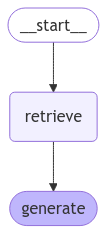

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Try it out

In [17]:
import json

def print_response(resp):
  as_dict = {
    'input': resp.get('input'),
    'chat_history': [doc.model_dump() for doc in resp.get('chat_history', [])],
    'context': [doc.model_dump() for doc in resp['context']],
    'answer': resp['answer']
  }
  print(json.dumps(as_dict, indent=2) + '\n')

session_id = 'abc123'
config = {'configurable': {'thread_id': session_id}}

# resp = graph.invoke({'question': 'What are croquet lawns?'})
# print_response(resp)
# print(f"{resp['answer']['answer']} (source: {'; '.join(resp['answer']['sources'])})")

graph.invoke({'question': 'What are croquet lawns?'}, config)['answer']['answer']



'Croquet lawns are located in Town Square and are available for use on a first come, first served basis when the Croquet Club is not occupying them. Usage times are listed in SunSations magazine under the Croquet Club listing in the Chartered Club News section.'

In [16]:
graph.invoke({'question': 'Where was my last question?'}, config)['answer']['answer']

"I don't know where your last question was."